In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
import os
import transformers
import tqdm

if not os.path.exists('./pcgrad_repo'):
    !git clone https://github.com/WeiChengTseng/Pytorch-PCGrad
    !move Pytorch-PCGrad pcgrad_repo
from pcgrad_repo.pcgrad import PCGrad

# Set parameters

In [23]:
ENABLE_WANDB = False

#NOTE: sentiment always first in 'task' field (index 0), sarcasm second (index 1) where not in dictionary
#NOTE: task always lowercase, but check is always done
#NOTE: class '0' (negative) always first in classes list (index 0), class '1' (positive) second (index 1), etc.
#NOTE: if a task is not present, its classes list is empty (lenght of 0 not None)
#NOTE: BESSTIE dataset apply filter base on value of 'task', 'variety' and 'source' fields, 
# if None no filter applied for that field, only sample with correct values for label are kept (no nan)
# if task is 'sentiment' only sample with at least sentiment labels are kept,
# if 'sarcasm' only sample with at least sarcasm labels are kept
# EXAMPLE: task = 'sentiment', variety = 'en-IN', source = 'Reddit' means:
# keep only samples with sentiment labels not nan, variety 'en-IN' and source 'Reddit'

#TODO: check yelp dataset if compatible
#TODO: implement outomatic way to set min_length and max_length based on dataset statistics
#TODO: implement for bicodemix selection of task other than sarcasm-sentiment
train_dataset_CFGs = {
    'BESSTIE':{
        'dataset_name': 'BESSTIE',
        'root_folder': './dataset/besstie',
        'file_name': 'train_SS_with_nan.csv',
        'classes': {
            'sentiment': ['0', '1'],
            'sarcasm': ['0', '1'],
        },
        'task': 'sentiment-sarcasm',
        'variety': 'en-IN',
        'source': 'Reddit',
    },
    'yelp': {
        'dataset_name': 'yelp',
        'root_folder': './dataset/yelp',
        'file_name': 'yelp_filtered_reviews.csv',
        'classes': {
            'sentiment': ['useful', 'funny', 'cool'],
            'sarcasm': [],
        },
        'task': 'sentiment',
    },
    'bicodemix': {
        'dataset_name': 'bicodemix',
        'root_folder': './dataset/bicodemix',
        'file_name': 'train_SS.csv',
        'classes': {
            'sentiment': ['0', '1', '2'],
            'sarcasm': ['0', '1'],
        },
        'task': 'sarcasm-sentiment',
    },
    'twitter': {
        'dataset_name': 'twitter',
        'root_folder': './dataset/twitter',
        'file_name': 'twitter_sentiment_analysis.csv',
        'classes': {
            'sentiment': ['Negative', 'Positive'],
            'sarcasm': [],
        },
        'task': 'sentiment',
    }
}

training_dataset_name = 'BESSTIE'  # 'BESSTIE' or 'yelp' or 'bicodemix' or 'twitter'

valid_dataset_CFG = {
    'dataset_name': 'BESSTIE',
    'root_folder': './dataset/besstie',
    'file_name': 'valid_SS_with_nan.csv',
    'classes': {
        'sentiment': ['0', '1'],
        'sarcasm': ['0', '1'],
    },
    'task': train_dataset_CFGs[training_dataset_name]['task'],
    'variety': None,
    'source': None,
}

CFG = {
    'lr': 2e-5,
    'start_epoch': 0,
    'epochs': 3,
    'batch_size': 8,
    'max_length': 200,
    'min_length': 40,
    "train_dataset_CFG": {**train_dataset_CFGs[training_dataset_name]},
    "valid_dataset_CFG": {**valid_dataset_CFG},
    'model_name': 'bert-base-uncased',
    'classification_head': 'multi_task_conv', # ['linear', 'conv', 'lstm', 'multi_task_conv', 'cross_talk_conv']
    'seed': 0,
}

is_multitask = 'sentiment' in CFG['train_dataset_CFG']['task'].lower() and 'sarcasm' in CFG['train_dataset_CFG']['task'].lower()

if is_multitask:
    print("Training in multitask mode.")

    if CFG['classification_head'] in ['linear', 'conv', 'lstm']:
        print(f"Using {CFG['classification_head']} classification head (single task head) for multitask learning. Aborting...")
        exit(1)

else:
    if CFG['classification_head'] in ['multi_task_conv', 'cross_talk_conv']:
        print(f"Using {CFG['classification_head']} classification head (multi-task head) for single task learning. Aborting...")
        exit(1)

# for wandb
run_name = f"{training_dataset_name}_{CFG['classification_head']}"

Training in multitask mode.


In [8]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG['seed'])

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


# Datasets

In [10]:
if not os.path.exists(os.path.join(CFG['train_dataset_CFG']['root_folder'], CFG['train_dataset_CFG']['file_name'])):
    raise Exception('Training file not found! Please check the train_dataset_CFG configuration.')

if not os.path.exists("./dataset/besstie/train.csv") or not os.path.exists("./dataset/besstie/valid.csv"):
    print("Downloading BESSTIE dataset...")
    # Login using e.g. `huggingface-cli login` to access this dataset
    df = pd.read_csv("hf://datasets/unswnlporg/BESSTIE/train.csv")
    df.to_csv("./dataset/besstie/train.csv", index=False)
    df = pd.read_csv("hf://datasets/unswnlporg/BESSTIE/valid.csv")
    df.to_csv("./dataset/besstie/valid.csv", index=False)
    print("BESSTIE dataset downloaded.")

In [11]:
def get_dataset(dataset_CFG, minlength, maxlength, tokenizer):
    dataset_name = dataset_CFG['dataset_name'].lower()
    if dataset_name == 'twitter':
        from dataset.twitter.dataset_twitter import TwitterDataSet
        dataset = TwitterDataSet(
            **dataset_CFG, 
            tokenizer=tokenizer,
            minlength=minlength,
            maxlength=maxlength
        )
    elif dataset_name == 'besstie':
        from dataset.besstie.dataset_besstie import BesstieDataSet
        dataset = BesstieDataSet(
            **dataset_CFG, 
            tokenizer=tokenizer,
            minlength=minlength,
            maxlength=maxlength,
        )
    elif dataset_name == 'bicodemix':
        from dataset.bicodemix.dataset_bicodemix import BicodemixDataSet
        dataset = BicodemixDataSet(
            **dataset_CFG, 
            tokenizer=tokenizer,
            minlength=minlength,
            maxlength=maxlength,
        )
    elif dataset_name == 'yelp':
        #TODO: implement Yelp dataset class
        raise Exception("Yelp dataset not yet implemented.")
    else:
        raise Exception(f"Dataset {dataset_name} not recognized.")
    return dataset


# Model

## Head

In [12]:
class MultiKernelConvs(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        kernel_sizes=(2, 3, 5),
        dropout=0.1
    ):
        super().__init__()

        self.convs = torch.nn.ModuleList([
            torch.nn.Conv1d(
                in_channels=input_size,
                out_channels=hidden_size//len(kernel_sizes),
                kernel_size=k,
                padding=k // 2
            )
            for k in kernel_sizes
        ])

        self.activation = torch.nn.ReLU()
        self.pool = torch.nn.AdaptiveAvgPool1d(1)
        self.dropout = torch.nn.Dropout(dropout)
        self.flatten = torch.nn.Flatten()

        # self.classifier = torch.nn.Linear(
        #     hidden_size * len(kernel_sizes),
        #     num_labels
        # )

    def forward(self, x):
        # x: (B, H, L)
        conv_outputs = []

        for conv in self.convs:
            h = self.activation(conv(x))      # (B, C, L)
            h = self.pool(h).squeeze(-1)       # (B, C)
            conv_outputs.append(h)

        x = torch.cat(conv_outputs, dim=1)    # (B, C * num_kernels)
        x = self.flatten(self.dropout(x))
        # logits = self.classifier(x)

        return x

class ConvClassificationHead(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_labels=2, linear=True):
        super().__init__()

        if linear:
            self.conv = torch.nn.Sequential(
                MultiKernelConvs(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    kernel_sizes=(3,),
                ), # (B, hidden_size)
                torch.nn.Linear(hidden_size, num_labels)
            )
        else:
            self.conv = torch.nn.Sequential(
                MultiKernelConvs(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    kernel_sizes=(3,),
                ) # (B, hidden_size)
            )

    def forward(self, x):
        return self.conv(x)

class MultiTaskConvHead(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_sentiment_labels: int,
        num_sarcasm_labels: int
    ):
        super().__init__()

        self.sentiment_head = ConvClassificationHead(
            input_size=input_size,
            hidden_size=hidden_size,
            num_labels=num_sentiment_labels
        )

        self.sarcasm_head = ConvClassificationHead(
            input_size=input_size,
            hidden_size=hidden_size,
            num_labels=num_sarcasm_labels
        )

    def forward(self, sequence_output):
        """
        sequence_output: last_hidden_state from BERT
        shape: (batch, seq_len, hidden_size)
        """
        sentiment_logits = self.sentiment_head(sequence_output)
        sarcasm_logits = self.sarcasm_head(sequence_output)
        
        return {
            "sentiment": sentiment_logits,
            "sarcasm": sarcasm_logits
        }

class CrossTalkHead(torch.nn.Module):
    def __init__(
        self,
        input_size,
        conv_hidden_size,
        num_sentiment_labels,
        num_sarcasm_labels,
    ):
        super().__init__()

        self.encoder = ConvClassificationHead(
            input_size=input_size,
            hidden_size=conv_hidden_size,
            linear = False
        )

        # task-specific embeddings
        self.sentiment_embed = torch.nn.Linear(
            conv_hidden_size, conv_hidden_size
        )
        self.sarcasm_embed = torch.nn.Linear(
            conv_hidden_size, conv_hidden_size
        )

        # cross-talk layers
        self.sentiment_fuse = torch.nn.Linear(
            2 * conv_hidden_size, conv_hidden_size
        )
        self.sarcasm_fuse = torch.nn.Linear(
            2 * conv_hidden_size, conv_hidden_size
        )

        self.sentiment_out = torch.nn.Linear(
            # conv_hidden_size, np.max([num_sentiment_labels, num_sarcasm_labels])
            conv_hidden_size, num_sentiment_labels
        )
        self.sarcasm_out = torch.nn.Linear(
            conv_hidden_size, num_sarcasm_labels
        )

    def forward(self, sequence_output):
        shared = self.encoder(sequence_output)

        # first linear layer
        sent_feat = self.sentiment_embed(shared)
        sarc_feat = self.sarcasm_embed(shared)

        # cross-talk
        sent_feat_cross = self.sentiment_fuse(
            torch.cat([sarc_feat, sent_feat], dim=-1)
        )
        sarc_feat_cross = self.sarcasm_fuse(
            torch.cat([sarc_feat, sent_feat], dim=-1)
        )

        return {
            "sentiment": self.sentiment_out(sent_feat_cross),
            "sarcasm": self.sarcasm_out(sarc_feat_cross)
        }

In [13]:
def get_classification_head(method: str, input_size:int, hidden_size: int, num_labels: int):
    num_sent_labels, num_sarc_labels = num_labels

    # Single task case
    if num_sent_labels == 0 or num_sarc_labels == 0:
        num_task_labels = max(num_sent_labels, num_sarc_labels)
    
    if method == "linear":
        return torch.nn.Linear(input_size, num_task_labels)
    elif method == "conv":
        return ConvClassificationHead(input_size, hidden_size, num_task_labels)
    elif method == "lstm":
        return torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
    elif method == "multi_conv":
        return torch.nn.Sequential(
            MultiKernelConvs(
                input_size=input_size,
                hidden_size=hidden_size,
                kernel_sizes=(2, 3, 5),
                dropout=0.1
            ),
            torch.nn.Linear(hidden_size, num_task_labels)
        )
    elif method == 'multi_task_conv':
        return MultiTaskConvHead(input_size, hidden_size, num_sent_labels, num_sarc_labels)
    elif method == 'cross_talk_conv':
        return CrossTalkHead(input_size, hidden_size, num_sent_labels, num_sarc_labels)
    else:
        raise ValueError(f"Unknown classification head method: {method}")

## Back-bone and tokenizer

In [14]:
def get_tokenizer_and_model(model_name:str):
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    model = transformers.AutoModel.from_pretrained(model_name)
    return tokenizer, model

## Classifier

In [15]:
class MyClassifier(torch.nn.Module):
    def __init__(self, base_model_name, classification_head_name, num_labels):
        super().__init__()

        num_sent_labels, num_sarc_labels = num_labels

        # Single task case
        if num_sent_labels == 0 or num_sarc_labels == 0:
            num_task_labels = max(num_sent_labels, num_sarc_labels)
        
        self.tokenizer, self.base_model = get_tokenizer_and_model(base_model_name)
        self.hidden_size = self.base_model.config.hidden_size
        self.dropout = torch.nn.Dropout(self.base_model.config.hidden_dropout_prob)

        self.classification_head_name = classification_head_name

        self.classification_head = get_classification_head(
            classification_head_name, self.hidden_size, self.hidden_size, num_labels
        )

        if classification_head_name == "lstm":
            self.output_layer = torch.nn.Linear(self.hidden_size*2, num_task_labels)

    def get_tokenizer(self) -> transformers.PreTrainedTokenizer:
        return self.tokenizer

    def forward(self, inputs):
        outputs = self.base_model(**inputs)
        sequence = self.dropout(outputs.last_hidden_state)

        if self.classification_head_name == "linear":
            cls_rep = sequence[:, 0, :]
            logits = self.classification_head(cls_rep)

        elif self.classification_head_name == "conv":
            # x: (batch, seq_len, hidden_size)
            x = sequence.transpose(1, 2)  # -> (batch, hidden_size, seq_len)
            logits = self.classification_head(x)

        elif self.classification_head_name == "lstm":
            #TODO: check if works correctly
            lstm_out, _ = self.classification_head(sequence)
            cls_rep = lstm_out[:, 0, :]
            logits = self.output_layer(cls_rep)

        elif self.classification_head_name == 'multi_conv':
            # TODO: implement
            logits = None

        elif self.classification_head_name == 'multi_task_conv':
            x = sequence.transpose(1, 2)
            logits = self.classification_head(x)

        elif self.classification_head_name == 'cross_talk_conv':
            x = sequence.transpose(1, 2)
            logits = self.classification_head(x)

        return logits


# Train

## Multitask

In [16]:
def train_SS(model, train_loader, optimizer, criterion, device):
    model.train()

    train_sarc_loss = 0.0
    train_sent_loss = 0.0
    train_sarc_acc = 0.0
    train_sent_acc = 0.0
    c1, c2 = criterion

    pbar = tqdm.tqdm(train_loader)
    for batch in pbar:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }

        local_labels = batch['label'].to(device)
        outputs = model(inputs)

        sent_loss = c1(outputs['sentiment'], local_labels[:,0])
        sarc_loss = c2(outputs['sarcasm'], local_labels[:,1])

        loss = sarc_loss + sent_loss
        loss.backward()
        # optimizer.pc_backward([sarc_loss, sent_loss])
        optimizer.step()
        optimizer.zero_grad()

        train_sarc_loss += sarc_loss.item()
        train_sent_loss += sent_loss.item()

        _, preds_sarc = torch.max(outputs['sarcasm'], dim=1)
        _, preds_sent = torch.max(outputs['sentiment'], dim=1)
        train_sarc_acc += torch.sum(preds_sarc == local_labels[:,1]).item()
        train_sent_acc += torch.sum(preds_sent == local_labels[:,0]).item()

    return train_sarc_loss / len(train_loader), train_sent_loss / len(train_loader), train_sarc_acc / (len(train_loader.dataset)), train_sent_acc / (len(train_loader.dataset))


## Singletask

In [17]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    pbar = tqdm.tqdm(train_loader)
    for batch in pbar:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }

        local_labels = batch['label'].flatten().to(device)
        outputs = model(inputs)

        loss = criterion(outputs, local_labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        train_acc += torch.sum(preds == local_labels).item()

    return train_loss / len(train_loader), train_acc / (len(train_loader.dataset))

# Validation

## Multitask

In [18]:
def validate_SS(model, val_loader, criterion, device):
    model.eval()
    val_sarc_acc = 0.0
    val_sent_acc = 0.0
    val_sarc_loss = 0.0
    val_sent_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            local_labels = batch['label'].to(device)
            outputs = model(inputs)

            sentiment_criterion, sarcasm_criterion = criterion
            sarc_loss = sarcasm_criterion(outputs['sarcasm'], local_labels[:,1])
            sent_loss = sentiment_criterion(outputs['sentiment'], local_labels[:,0])

            _, preds_sarc = torch.max(outputs['sarcasm'], dim=1)
            _, preds_sent = torch.max(outputs['sentiment'], dim=1)

            val_sent_acc += torch.sum(preds_sent == local_labels[:,0]).item()
            val_sarc_acc += torch.sum(preds_sarc == local_labels[:,1]).item()

            val_sarc_loss += sarc_loss.item()
            val_sent_loss += sent_loss.item()

    return val_sarc_loss / len(val_loader), val_sarc_acc / len(val_loader.dataset), val_sent_loss / len(val_loader), val_sent_acc / len(val_loader.dataset)

## Singletask

In [19]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_acc = 0.0
    val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            local_labels = batch['label'].flatten().to(device)
            outputs = model(inputs)

            loss = criterion(outputs, local_labels)
            _, preds = torch.max(outputs, dim=1)
            val_acc += torch.sum(preds == local_labels).item()
            val_loss += loss.item()

    return val_loss / len(val_loader), val_acc / len(val_loader.dataset)

# Wandb

In [29]:
if CFG['train_dataset_CFG'].get('variety', None) == None:
    run_id = f"{CFG['model_name']}_{CFG['classification_head']}_{CFG['train_dataset_CFG']['dataset_name']}"
else:
    run_id = f"{CFG['model_name']}_{CFG['classification_head']}_{CFG['train_dataset_CFG']['dataset_name']}_{CFG['train_dataset_CFG']['variety']}"
if ENABLE_WANDB:
    import wandb
    # NOTE: set run_name
    # run_id = None

    run = wandb.init(
        entity="elena-nespolo02-politecnico-di-torino",
        project="Figurative Analysis",
        name=run_name,
        id=run_id,
        resume="allow",
        config=CFG,
        tags=[CFG['train_dataset_CFG']['dataset_name'], CFG['train_dataset_CFG']['task'], CFG['model_name']]
    )

    wandb.define_metric("epoch/step")
    wandb.define_metric("epoch/*", step_metric="epoch/step")

    wandb.define_metric("train/step")
    wandb.define_metric("train/*", step_metric="train/step")

    wandb.define_metric("validate/step")
    wandb.define_metric("validate/*", step_metric="validate/step")



# ML pipeline

In [30]:
models_root_dir = "./models"
os.makedirs(models_root_dir, exist_ok=True)

model_name = CFG['model_name']
tokenizer, model = get_tokenizer_and_model(model_name)

tokenizer = transformers.BertTokenizer.from_pretrained(model_name)

# setup classifier model
model = MyClassifier(
    base_model_name=model_name,
    classification_head_name=CFG['classification_head'],
    num_labels=[len(v) if k in CFG['train_dataset_CFG']['task'].lower() else 0 for k,v in CFG['train_dataset_CFG']['classes'].items()]
).to(device)

train_ds = get_dataset(
    CFG['train_dataset_CFG'], 
    minlength=CFG['min_length'],
    maxlength=CFG['max_length'],
    tokenizer=tokenizer,
)
val_ds = get_dataset(
    CFG['valid_dataset_CFG'], 
    minlength=CFG['min_length'],
    maxlength=CFG['max_length'],
    tokenizer=tokenizer,
)

print("Training dataset size:", len(train_ds))
print("Validation dataset size:", len(val_ds))

labels_count = {}
for t, cs in train_ds.get_label_count().items():
    if t in CFG['train_dataset_CFG']['task'].lower():
        labels_count[t] = [c for c in cs.values()]
print(labels_count)

if is_multitask:
    optimizer = PCGrad(torch.optim.Adam(model.parameters(), lr=CFG['lr']))
    sarc_weights = labels_count['sarcasm']
    sent_weights = labels_count['sentiment']
    sum_sarc = sum(sarc_weights)
    sum_sent = sum(sent_weights)
    sarcasm_criterion = torch.nn.CrossEntropyLoss(
        weight=torch.tensor([sw/sum_sarc for sw in sarc_weights], dtype=torch.float).to(device)
    )
    sentiment_criterion = torch.nn.CrossEntropyLoss(
        weight=torch.tensor([sw/sum_sent for sw in sent_weights], dtype=torch.float).to(device)
    )
    criterion = [sentiment_criterion, sarcasm_criterion] # a list of per-task losses
    print([
        x.weight for x in criterion
    ])
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
    weights = labels_count[list(labels_count.keys())[0]]
    criterion = torch.nn.CrossEntropyLoss(
        weight=torch.tensor([w/sum(weights) for w in weights], dtype=torch.float).to(device)
    )

train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=CFG['batch_size'],
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=CFG['batch_size'],
    shuffle=False
)

# Loading form a starting point
if CFG['start_epoch'] > 0 and ENABLE_WANDB:
    artifact = run.use_artifact(f'elena-nespolo02-politecnico-di-torino/Figurative Analysis/{run_id}:epoch_{CFG['start_epoch']}', type='model')
    artifact_dir = artifact.download()

    artifact_path = os.path.join(artifact_dir, run_id+f"_epoch_{CFG['start_epoch']}.pth")

    checkpoint = torch.load(artifact_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    if not is_multitask:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    else:
        optimizer.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

Training dataset size: 1167
Validation dataset size: 112
{'sentiment': [1256, 429], 'sarcasm': [1017, 150]}
[tensor([0.7454, 0.2546], device='cuda:0'), tensor([0.8715, 0.1285], device='cuda:0')]


## Main Loop

In [31]:
for epoch in range(CFG['start_epoch']+1,CFG['epochs']+1):
    print(f"Epoch {epoch}/{CFG['epochs']}")

    if is_multitask:
        epoch_sarc_loss, epoch_sent_loss, epoch_sarc_acc, epoch_sent_acc = train_SS(model, train_loader, optimizer, criterion, device)

        val_sarc_loss, val_sarc_acc, val_sent_loss, val_sent_acc = validate_SS(model, val_loader, criterion, device)

        if ENABLE_WANDB:
            run.log({
                    "epoch/step": epoch,
                    "epoch/train_sarc_loss": epoch_sarc_loss,
                    "epoch/train_sent_loss": epoch_sent_loss,
                    "epoch/train_sarc_acc": epoch_sarc_acc,
                    "epoch/train_sent_acc": epoch_sent_acc,
                    "epoch/val_sarc_loss": val_sarc_loss,
                    "epoch/val_sent_loss": val_sent_loss,
                    "epoch/val_sarc_acc": val_sarc_acc,
                    "epoch/val_sent_acc": val_sent_acc
                },
                commit=True,
            )
        print(f"Training Sarcasm Loss: {epoch_sarc_loss:.4f}")
        print(f"Training Sentiment Loss: {epoch_sent_loss:.4f}")
        print(f"Training Sarcasm Acc: {epoch_sarc_acc:.4f}")
        print(f"Training Sentiment Acc: {epoch_sent_acc:.4f}")
        print(f"Validation Sarcasm Loss: {val_sarc_loss:.4f}")
        print(f"Validation Sentiment Loss: {val_sent_loss:.4f}")
        print(f"Validation Sarcasm Acc: {val_sarc_acc:.4f}")
        print(f"Validation Sentiment Acc: {val_sent_acc:.4f}")

    else:
        epoch_loss, epoch_acc = train(model, train_loader, optimizer, criterion, device)

        val_loss, val_acc = validate(model, val_loader, criterion, device)

        if ENABLE_WANDB:
            run.log({
                    "epoch/step": epoch,
                    "epoch/train_loss": epoch_loss,
                    "epoch/train_acc": epoch_acc,
                    "epoch/val_loss": val_loss,
                    "epoch/val_acc": val_acc
                },
                commit=True,
            )

        print(f"Training Loss: {epoch_loss:.4f}")
        print(f"Training Acc: {epoch_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Acc: {val_acc:.4f}")

    if (epoch % 3) == 0 or (epoch == CFG['epochs']):
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.optimizer.state_dict() if is_multitask else optimizer.state_dict(),
            "epoch/step": epoch
        }

        file_name = f"{run_id}_epoch_{epoch}.pth"

        # Saving the progress
        file_path = os.path.join(models_root_dir, file_name)
        torch.save(checkpoint, file_path)

        print(f"Model saved to {file_path}")

        if ENABLE_WANDB:
            artifact = wandb.Artifact(name=run_id, type="model")
            artifact.add_file(file_path)

            run.log_artifact(artifact, aliases=["latest", f"epoch_{epoch}"])

if ENABLE_WANDB:
    run.finish()

Epoch 1/3


100%|██████████| 146/146 [00:24<00:00,  5.97it/s]


Training Sarcasm Loss: 0.1429
Training Sentiment Loss: 0.3425
Training Sarcasm Acc: 0.8655
Training Sentiment Acc: 0.7558
Validation Sarcasm Loss: 0.1657
Validation Sentiment Loss: 0.3828
Validation Sarcasm Acc: 0.8125
Validation Sentiment Acc: 0.5804
Epoch 2/3


100%|██████████| 146/146 [00:24<00:00,  5.93it/s]


Training Sarcasm Loss: 0.1025
Training Sentiment Loss: 0.2331
Training Sarcasm Acc: 0.8715
Training Sentiment Acc: 0.8415
Validation Sarcasm Loss: 0.1573
Validation Sentiment Loss: 0.2308
Validation Sarcasm Acc: 0.8125
Validation Sentiment Acc: 0.8750
Epoch 3/3


100%|██████████| 146/146 [00:24<00:00,  5.89it/s]


Training Sarcasm Loss: 0.0844
Training Sentiment Loss: 0.1168
Training Sarcasm Acc: 0.8792
Training Sentiment Acc: 0.9314
Validation Sarcasm Loss: 0.1538
Validation Sentiment Loss: 0.2435
Validation Sarcasm Acc: 0.8214
Validation Sentiment Acc: 0.8750
Model saved to ./models\bert-base-uncased_multi_task_conv_BESSTIE_en-IN_epoch_3.pth


## If crash happens run following cell

In [ ]:
if ENABLE_WANDB:
    run.finish()

# Testing

## Load a model

In [32]:
def get_model(CFG, run_id, epoch, device):
    model = MyClassifier(
        base_model_name=CFG['model_name'],
        classification_head_name=CFG['classification_head'],
        num_labels=[len(v) if k in CFG['train_dataset_CFG']['task'].lower() else 0 for k,v in CFG['train_dataset_CFG']['classes'].items()]
    ).to(device)

    if not os.path.exists(models_root_dir):
        artifact = run.use_artifact(f'elena-nespolo02-politecnico-di-torino/Figurative Analysis/{run_id}:epoch_{epoch}', type='model')
        artifact_dir = artifact.download()

        artifact_path = os.path.join(artifact_dir, run_id+f"_epoch_{epoch}.pth")

        checkpoint = torch.load(artifact_path, map_location=device)

    else:
        file_name = f"{run_id}_epoch_{epoch}.pth"
        model_path = os.path.join(models_root_dir, file_name)

        checkpoint = torch.load(model_path, map_location=device)
    
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    return model

## For each variety

In [ ]:
results = {}

# Loading the trained model
test_model = get_model(CFG, run_id, 3, device)

#TODO: ability to test on sample with subset of the task, from sentiment-sarcasm to only sentiment and only sarcasm
for variety in ['en-AU', 'en-IN', 'en-UK']:
    print(f"Testing on variety: {variety}")
    for source in ['Reddit', 'Google']:
        print(f"\tTesting on source: {source}")

        dataset_CFG = CFG['valid_dataset_CFG'].copy()
        dataset_CFG['variety'] = variety
        dataset_CFG['source'] = source
        dataset_CFG['task'] = CFG['train_dataset_CFG']['task']

        from dataset.besstie import dataset_besstie

        tokenizer = model.get_tokenizer()
        test_ds = dataset_besstie.BesstieDataSet(
            **dataset_CFG,
            tokenizer=tokenizer,
            min_length=1,
            max_length=200,
        )

        test_loader = torch.utils.data.DataLoader(
            test_ds,
            batch_size=CFG['batch_size'],
            shuffle=False
        )
        print(dataset_CFG)
        print(f"\t\tTest dataset size: {len(test_ds)}")
        if is_multitask:
            optimizer = PCGrad(torch.optim.Adam(model.parameters(), lr=CFG['lr']))
            sarc_weights = labels_count['sarcasm']
            sent_weights = labels_count['sentiment']
            sum_sarc = sum(sarc_weights)
            sum_sent = sum(sent_weights)
            sarcasm_criterion = torch.nn.CrossEntropyLoss(
                weight=torch.tensor([sw/sum_sarc for sw in sarc_weights], dtype=torch.float).to(device)
            )
            sentiment_criterion = torch.nn.CrossEntropyLoss(
                weight=torch.tensor([sw/sum_sent for sw in sent_weights], dtype=torch.float).to(device)
            )
            criterion = [sarcasm_criterion, sentiment_criterion] # a list of per-task losses

            test_sarc_loss, test_sarc_acc, test_sent_loss, test_sent_acc = validate_SS(test_model, test_loader, criterion, device)
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
            weights = labels_count[list(labels_count.keys())[0]]
            criterion = torch.nn.CrossEntropyLoss(
                weight=torch.tensor([w/sum(weights) for w in weights], dtype=torch.float).to(device)
            )

            test_loss, test_acc = validate(test_model, test_loader, criterion, device)

        results[(variety, source)] = {
            'loss': test_loss if not is_multitask else (test_sarc_loss, test_sent_loss),
            'acc': test_acc if not is_multitask else (test_sarc_acc, test_sent_acc)
        }


Testing on variety: en-AU
	Testing on source: Reddit
{'dataset_name': 'BESSTIE', 'root_folder': './dataset/besstie', 'file_name': 'valid_SS_with_nan.csv', 'classes': {'sentiment': ['0', '1'], 'sarcasm': ['0', '1']}, 'task': 'sentiment-sarcasm', 'variety': 'en-AU', 'source': 'Reddit'}
		Test dataset size: 23
	Testing on source: Google
{'dataset_name': 'BESSTIE', 'root_folder': './dataset/besstie', 'file_name': 'valid_SS_with_nan.csv', 'classes': {'sentiment': ['0', '1'], 'sarcasm': ['0', '1']}, 'task': 'sentiment-sarcasm', 'variety': 'en-AU', 'source': 'Google'}
		Test dataset size: 15
Testing on variety: en-IN
	Testing on source: Reddit
{'dataset_name': 'BESSTIE', 'root_folder': './dataset/besstie', 'file_name': 'valid_SS_with_nan.csv', 'classes': {'sentiment': ['0', '1'], 'sarcasm': ['0', '1']}, 'task': 'sentiment-sarcasm', 'variety': 'en-IN', 'source': 'Reddit'}
		Test dataset size: 22
	Testing on source: Google
{'dataset_name': 'BESSTIE', 'root_folder': './dataset/besstie', 'file_na

Final Results


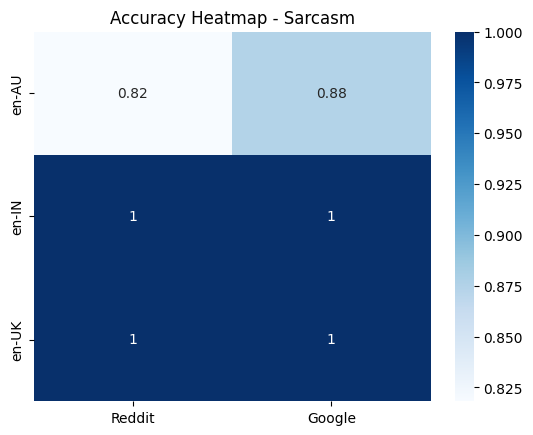

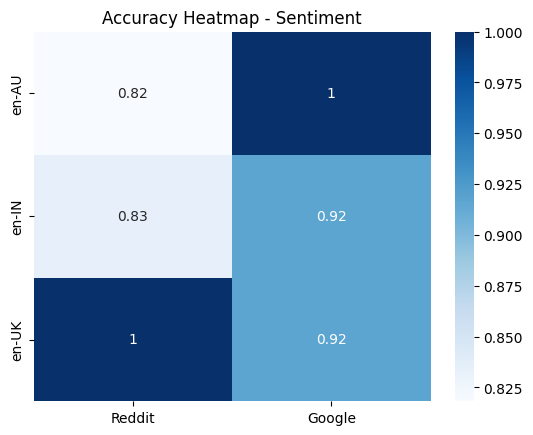

In [34]:
print("Final Results")
import seaborn as sns

if not is_multitask:
    plt.figure()
    sns.heatmap(
        np.array([v['acc'] for v in results.values()]).reshape(3,2),
        annot=True,
        xticklabels=['Reddit', 'Google'],
        yticklabels=['en-AU', 'en-IN', 'en-UK'],
        cmap='Blues'
    )
    plt.title('Accuracy Heatmap')
else:
    for i,task in enumerate(['sarcasm', 'sentiment']):
        plt.figure()
        data = np.array([v['acc'][i] for v in results.values()]).reshape(3,2)
        sns.heatmap(
            data,
            annot=True,
            xticklabels=['Reddit', 'Google'],
            yticklabels=['en-AU', 'en-IN', 'en-UK'],
            cmap='Blues'
        )
        plt.title(f'Accuracy Heatmap - {task.capitalize()}')